In [1]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

# Specify the path to the main directory, this is the segment-anything-2 path
main_directory = "/home/asdasd/segment-anything-2"

# Change the current working directory to the main directory
os.chdir(main_directory)

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

#### Utility functions to show results of YOLO segmentations, using OpenCV (Not recomended)

In [3]:
def resize_yolo_masks_tensor(segmentation_result):
    """
    Resizes YOLO segmentation masks to their original image shape.

    This function takes a segmentation result from a YOLO model that contains masks,
    resizes each mask to the original shape of the image from which it was predicted,
    and returns the resized masks as a NumPy array of type uint8.

    Parameters:
    segmentation_result (list): A list of segmentation result objects. Each object should
                                have an attribute `masks` with two properties:
                                - `data`: A torch tensor of shape (N, H, W) where N is the 
                                          number of masks, H is the height, and W is the width.
                                - `orig_shape`: A tuple (original_height, original_width) which
                                                represents the original shape of the image.

    Returns:
    np.ndarray: A NumPy array of resized masks of shape (N, original_height, original_width) and type uint8.
                Each mask is resized to the original dimensions of the image.
                
    Example:
    segmentation_result = model(input)
    resized_masks = resize_yolo_masks_tensor(segmentation_result)
    """

    original_shape = segmentation_result[0].masks.orig_shape
    masks = segmentation_result[0].masks.data  # masks.shape = torch.Size([N, H, W]) = (mask_number, height, width)
    
    # Reshape the masks tensor to add a channel dimension which is needed for F.interpolate
    masks = masks.unsqueeze(1)  # masks.shape becomes torch.Size([N, 1, H, W])
    
    # Interpolate the masks to the original_shape
    resized_masks = F.interpolate(masks, size=original_shape, mode='nearest')
    
    # Remove the channel dimension
    resized_masks = resized_masks.squeeze(1)  # resized_masks.shape becomes torch.Size([N, original_shape[0], original_shape[1]])
    
    # Convert the resized masks to a NumPy array and ensure type uint8
    resized_masks = resized_masks.cpu().numpy().astype(np.uint8)
    
    return resized_masks


def draw_rectangles(canvas, rectangles, line_color=(0, 255, 0)):
    """
    Draws rectangles on a copy of the canvas image.

    Args:
        canvas (numpy.ndarray): The original image to draw rectangles on.
        rectangles (list of tuples): List of [x, y, w, h] where (x, y) is the top-left corner and (w, h) is the width and height of the rectangle.
        line_color (tuple): Color of the rectangle border in BGR format. Default is green.

    Returns:
        numpy.ndarray: A new image with rectangles drawn on it, keeping the original image intact.
    """
    # Create a copy of the canvas image
    image_with_boxes = canvas.copy()
    
    # Draw rectangles on the copied image
    for (x, y, w, h) in rectangles:
        # Determine the box positions
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        # Draw the rectangle
        image_with_boxes = cv2.rectangle(image_with_boxes, top_left, bottom_right, line_color, thickness=cv2.LINE_4)

    return image_with_boxes


def draw_yolo_mask(canvas, masks, random_color=False, borders=True):
    """
    Draws the segmentation masks onto the canvas image, resizing them if necessary.

    Args:
        canvas (numpy.ndarray): The image on which to draw the masks.
        masks (torch.Tensor): A tensor of shape [number of masks, height, width] containing the mask data.
        random_color (bool): If True, each mask will be drawn with a random color. Default is False.
        borders (bool): If True, borders will be drawn around the masks. Default is True.
    
    Returns:
        numpy.ndarray: The canvas image with the masks drawn.
    """
    # Get the dimensions of the canvas
    canvas_height, canvas_width = canvas.shape[:2]

    # Loop over each mask
    for mask in masks:
        
        # Resize the mask to fit the canvas size
        #resized_mask = cv2.resize(mask, (canvas_width, canvas_height), interpolation=cv2.INTER_NEAREST)
        
        if random_color:
            color = [random.randint(0, 255) for _ in range(3)]  # Generate a random color
        else:
            color = (0, 255, 0)  # Default green color
        
        # Create a color image for the mask
        colored_mask = np.zeros_like(canvas, dtype=np.uint8)
        colored_mask[mask > 0] = color
        
        # Overlay the mask onto the canvas
        canvas = cv2.addWeighted(canvas, 1.0, colored_mask, 0.5, 0)
        
        if borders:
            # Find contours around the mask
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            mask_image = cv2.drawContours(canvas, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    
    return mask_image


def draw_sam2_mask(canvas, masks, random_color=False, borders=True):
    """
    Draws the segmentation masks onto the canvas image.
    Args:
        canvas (numpy.ndarray): The image on which to draw the masks.
        masks (numpy.ndarray): A numpy array of shape [num_predicted_masks_per_input, height, width]
                               or [num_predicted_masks_per_input, batch_size, height, width] containing the mask data.
        random_color (bool): If True, each mask will be drawn with a random color. Default is False.
        borders (bool): If True, borders will be drawn around the masks. Default is True.
    
    Returns:
        numpy.ndarray: The canvas image with the masks drawn.
    """
    
    def process_mask(mask):
        nonlocal result_canvas
        if random_color:
            color = [random.randint(0, 255) for _ in range(3)]
        else:
            color = [30, 144, 255]  # SAM2 default color
        
        alpha = 0.6
        colored_mask = np.zeros_like(result_canvas, dtype=np.uint8)
        colored_mask[mask > 0] = color
        
        result_canvas = cv2.addWeighted(result_canvas, 1.0, colored_mask, alpha, 0)

        if borders:
            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(result_canvas, contours, -1, (255, 255, 255), thickness=2)
    
    result_canvas = canvas.copy()
    
    print(masks.shape)
    if masks.ndim == 3:
        # Single bbox case: [num_predicted_masks_per_input, height, width]
        for mask in masks:
            process_mask(mask)
    elif masks.ndim == 4:
        # Multiple bboxes case: [num_predicted_masks_per_input, batch_size, height, width]
        # Process each mask in batch
        for batch_idx in range(masks.shape[1]):
            for mask in masks[:, batch_idx]:
                process_mask(mask)
    else:
        raise ValueError("Unexpected masks dimensions. Expected 3D or 4D input.")
    
    return result_canvas

#### Utility functions to show results of SAM2 segmentations, using Matplotlib

In [4]:
from utility_functions import show_mask, show_points, show_box, show_masks

#### Utility functions to show results of SAM2 segmentations, using OpenCV

In [5]:
from utility_functions import draw_masks_on_image, draw_points, draw_boxes

### Load the YOLO and SAM2 Models

In [6]:
from ultralytics import YOLO

yolo_checkpoint = "yolo-sam-2/yolo_weights/Salmons_YOLOv8.pt"
yolo_segmentator = YOLO(model=yolo_checkpoint, task="segment")

In [7]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

### Load images from video
Frames are stored in a list of paths for each video frame, each frame is stored as a JPEG. This is not necesary when using the SAM2ImagePredictor class but is necesary for the SAM2VideoPredictor, so the code is shown here.

In [8]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "yolo-sam-2/videos/SHORT_verde"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
frame_paths = [os.path.join(video_dir, frame_name) for frame_name in frame_names]

#### Load a image

In [9]:
# Load the image using OpenCV
image = cv2.imread(frame_paths[60])

# Convert the image to RGB (OpenCV loads images in BGR by default)
image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#### Show with matplotlib

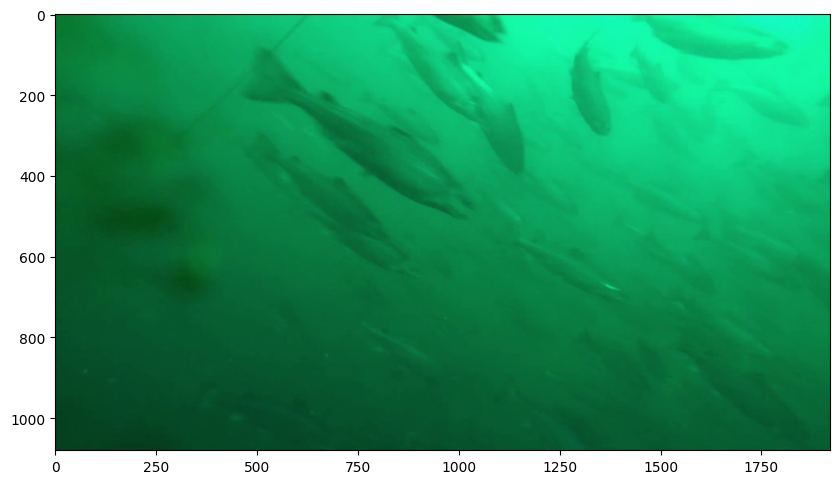

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(image_RGB)
plt.axis('on')
plt.show()

#### Display the image using OpenCV

In [11]:
cv2.imshow('Truck Image', cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2)))
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Obtain image bounding box using a YOLO detection

In [12]:
def get_bbox(yolo_model: YOLO, image):
    #segmentation_result = yolo_model.track(source=image, persist=True)
    segmentation_result = yolo_model.predict(source=image)
    yolo_bounding_boxes = np.array([bb.cpu().numpy() for bb in segmentation_result[0].boxes.xyxy], dtype=np.int16)
    return yolo_bounding_boxes

In [13]:
# Get the bboxes with YOLO
input_boxes = get_bbox(yolo_segmentator, image)
# Set the SAM2 predictor to the image
predictor.set_image(image_RGB)

input_boxes.shape


0: 384x640 18 salmons, 66.7ms
Speed: 2.5ms preprocess, 66.7ms inference, 86.9ms postprocess per image at shape (1, 3, 384, 640)


(18, 4)

#### Do inference with SAM2

In [14]:
masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)
masks.shape # (number of masks, batches (multimask_output), H, W)

(18, 1, 1080, 1920)

#### Show results with matplotlib

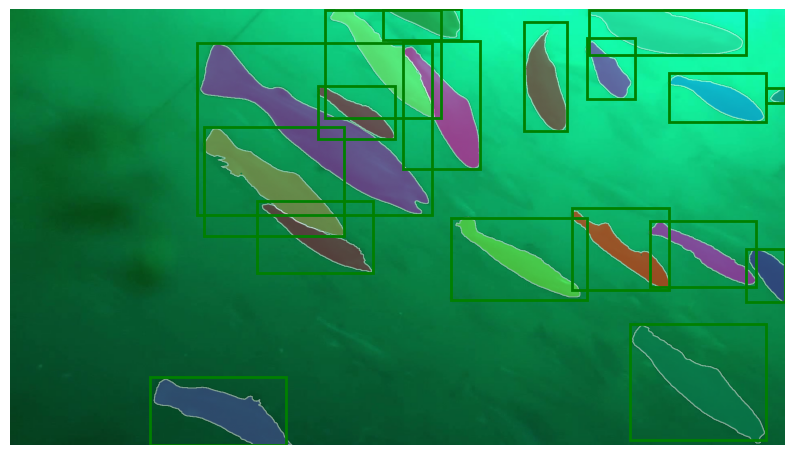

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(image_RGB)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

#### Show results with OpenCV

In [16]:
image_with_boxes = draw_boxes(image, input_boxes)
image_with_masks = draw_masks_on_image(image_with_boxes, masks, random_color=True, borders=True)

cv2.imshow('Image with Masks', cv2.resize(image_with_masks, (image_with_masks.shape[1] // 2, image_with_masks.shape[0] // 2)))

cv2.waitKey(0)
cv2.destroyAllWindows()